In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import statsmodels.api as sm
import seaborn as sns
import math
from datetime import datetime
import matplotlib.ticker as ticker
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 

/home/sara/.local/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_20975/3364076871.py:4: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (

# Divide data by displacement reason

In [2]:
disp_data = pd.read_excel(r"/home/sara/Documenti/GitHub/Climate-and-conflict/displacements/UNHCR-PRMN-Displacement-Dataset - Somalia.xlsx")
states_gdf = gpd.read_file(r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/som_adm_ocha_itos_20230308_shp/som_admbnda_adm1_ocha_20230308.shp")
df_d = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/df_lags_2016_n4c_disp_d.csv")
#df_d = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/df_lags_2016_n4_disp_fd.csv")
distance = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/dist_som.csv")
pop_density = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/population_density.csv")
pop_density['admin1'] = pop_density['admin1'].str.replace('_',' ')
df_d['admin1'] = df_d['admin1'].str.replace('_',' ')
inv_distance = 1/distance
df_d=pd.merge(df_d,pop_density,how='left',on=['year','admin1'],suffixes=('_norm', ''))
df_d = df_d.drop(['Awdal_x', 'Bakool_x', 'Banadir_x', 'Bari_x', 'Bay_x', 'Galgaduud_x',
       'Gedo_x', 'Hiraan_x', 'Lower_Juba_x', 'Lower_Shabelle_x',
       'Middle_Juba_x', 'Middle_Shabelle_x', 'Mudug_x', 'Nugaal_x', 'Sanaag_x',
       'Sool_x', 'Togdheer_x', 'Woqooyi_Galbeed_x', 'April', 'August',
       'December', 'February', 'January', 'July', 'June', 'March', 'May',
       'November', 'October', 'September', 'month_name','Awdal_y',
       'Bakool_y', 'Banadir_y', 'Bari_y', 'Bay_y', 'Galgaduud_y', 'Gedo_y',
       'Hiraan_y', 'Lower_Juba_y', 'Lower_Shabelle_y', 'Middle_Juba_y',
       'Middle_Shabelle_y', 'Mudug_y', 'Nugaal_y', 'Sanaag_y', 'Sool_y',
       'Togdheer_y', 'Woqooyi_Galbeed_y'], axis=1)

In [3]:
disp_data_d = disp_data[(disp_data['Reason']=='Drought related')]
disp_data_f = disp_data[(disp_data['Reason']=='Flood')]
disp_data_fd = disp_data[(disp_data['Reason']=='Drought related') | (disp_data['Reason']=='Flood')]
disp_data_c = disp_data[(disp_data['Reason']=='Conflict/Insecurity')]

agg_d=np.empty(4, dtype=object)
disp_matxs_d=np.empty(4, dtype=object)

for i,dd in enumerate([disp_data_d, disp_data_f, disp_data_fd, disp_data_c]):
    v= dd["Month End"]
    v=v.values
    dt = [datetime.strptime(v[j], "%d/%m/%Y") for j in range(len(v))]
    q=[]
    for j in range(len(dt)):
        q.append(datetime.timestamp(dt[j])) 
    dd.insert(loc=3, column='date_timestamp', value=q)
    dd=dd.sort_values("date_timestamp")
    dd['Month End'] = pd.to_datetime(dd['Month End'], dayfirst=True)

    #aggregate by district

    aggregated_data = dd.groupby([pd.Grouper(key='Month End', freq='M'), 'Previous (Departure) District', 'Current (Arrival) District']).agg({'Number of Individuals': 'sum', 'Current (Arrival) Region': 'first', 'Previous (Departure) Region': 'first'})
    dates = aggregated_data.index.get_level_values('Month End').unique()
    districts = aggregated_data.index.get_level_values('Previous (Departure) District').unique()
    all_combinations = pd.MultiIndex.from_product([dates, districts, districts], names=['time', 'Previous (Departure) District','Current (Arrival) District'])
    agg_d[i] = aggregated_data.reindex(all_combinations, fill_value=0).reset_index() 

    disp_matxs_d[i] = agg_d[i].pivot_table(index=['time','Previous (Departure) District'], columns='Current (Arrival) District', values='Number of Individuals', aggfunc='sum')
    disp_matxs_d[i]['year'] = disp_matxs_d[i].index.get_level_values('time').year

# to dictionary

agg_d = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], agg_d))
disp_matxs_d = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], disp_matxs_d))

In [4]:
regions = df_d['admin1'].unique()
region_codes = pd.factorize(regions)[0]
cmap = plt.cm.get_cmap('tab20', len(regions))

disp_matxs_d['drought']['year'] = disp_matxs_d['drought'].index.get_level_values('time').year
vac_lag = ['TA', 'TA_lag1', 'TA_lag2', 'TA_lag3', 'TA_lag4', 'TA_lag5']
lag_str = ['TA', 'TA_{lag1}', 'TA_{lag2}', 'TA_{lag3}', 'TA_{lag4}', 'TA_{lag5}']

/tmp/ipykernel_20975/3253414101.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(regions))


In [5]:
disp_matxs_d['flood']

Current (Arrival) District                Afgooye  Afmadow  Baardheere  \
time       Previous (Departure) District                                 
2016-04-30 Afgooye                              0        0           0   
           Afmadow                              0        0           0   
           Baardheere                           0        0           0   
           Badhaadhe                            0        0           0   
           Badhan                               0        0           0   
...                                           ...      ...         ...   
2023-08-31 Wanla Weyn                           0        0           0   
           Xarardheere                          0        0           0   
           Xudun                                0        0           0   
           Xudur                                0        0           0   
           Zeylac                               0        0           0   

Current (Arrival) District                Badhaadhe  Badhan  Baidoa  Baki  \
time       Previous (Departure) District                                    
2016-04-30 Afgooye                                0       0       0     0   
           Afmadow                                0       0       0     0   
           Baardheere                             0       0       0     0   
           Badhaadhe                              0       0       0     0   
           Badhan                                 0       0       0     0   
...                                             ...     ...     ...   ...   
2023-08-31 Wanla Weyn                             0       0       0     0   
           Xarardheere                            0       0       0     0   
           Xudun                                  0       0       0     0   
           Xudur                                  0       0       0     0   
           Zeylac                                 0       0       0     0   

Current (Arrival) District                Balcad  Banadir  Bandarbeyla  ...  \
time       Previous (Departure) District                                ...   
2016-04-30 Afgooye                             0        0            0  ...   
           Afmadow                             0        0            0  ...   
           Baardheere                          0        0            0  ...   
           Badhaadhe                           0        0            0  ...   
           Badhan                              0        0            0  ...   
...                                          ...      ...          ...  ...   
2023-08-31 Wanla Weyn                          0        0            0  ...   
           Xarardheere                         0        0            0  ...   
           Xudun                               0        0            0  ...   
           Xudur                               0        0            0  ...   
           Zeylac                              0        0            0  ...   

Current (Arrival) District                Saakow  Sablaale  Tayeeglow  Waajid  \
time       Previous (Departure) District                                        
2016-04-30 Afgooye                             0         0          0       0   
           Afmadow                             0         0          0       0   
           Baardheere                          0         0          0       0   
           Badhaadhe                           0         0          0       0   
           Badhan                              0         0          0       0   
...                                          ...       ...        ...     ...   
2023-08-31 Wanla Weyn                          0         0          0       0   
           Xarardheere                         0         0          0       0   
           Xudun                               0         0          0       0   
           Xudur                               0         0          0       0   
           Zeylac                  

# Concatenate each destination 

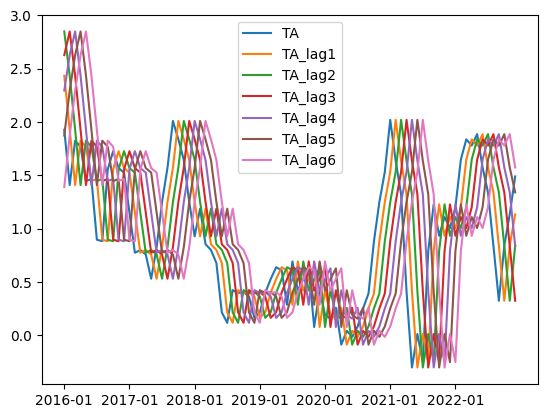

In [6]:
pl_1 = df_d[df_d['admin1']=='Awdal']

#plot TA, TA_lag1, .. against time in te same plot
fig, ax = plt.subplots()
ax.plot(pl_1['time'], pl_1['TA'], label='TA')
ax.plot(pl_1['time'], pl_1['TA_lag1'], label='TA_lag1')
ax.plot(pl_1['time'], pl_1['TA_lag2'], label='TA_lag2')
ax.plot(pl_1['time'], pl_1['TA_lag3'], label='TA_lag3')
ax.plot(pl_1['time'], pl_1['TA_lag4'], label='TA_lag4')
ax.plot(pl_1['time'], pl_1['TA_lag5'], label='TA_lag5')
ax.plot(pl_1['time'], pl_1['TA_lag6'], label='TA_lag6')
#change x axis to show only the years
ax.set_xticks(pl_1['time'][::12])
ax.legend()
plt.show()

# Concatenate each destination 

In [9]:
df_d

,index,time,admin1,tmx,pre,conflicts,year,month,TA,PA,...,DL_lag6,conflicts_lag1,conflicts_lag2,conflicts_lag3,conflicts_lag4,conflicts_lag5,conflicts_lag6,yr_mth,sum_disp,population_density
0,1380,2016-01,Awdal,30.050001,3.775000,4.0,2016,1,1.928297,-0.380389,...,85.0,4.0,6.0,9.0,6.0,1.0,1.0,2016-01,89,141.666530
1,1380,2016-01,Bakool,34.450000,1.612500,6.0,2016,1,1.763821,0.482869,...,85.0,8.0,4.0,2.0,12.0,7.0,18.0,2016-01,0,103.529746
2,1380,2016-01,Banadir,33.190000,6.130000,36.0,2016,1,0.945572,0.199790,...,6.0,33.0,42.0,34.0,30.0,33.0,49.0,2016-01,0,6288.475825
3,1380,2016-01,Bari,29.037500,4.045833,6.0,2016,1,2.795625,0.105978,...,16.0,8.0,4.0,2.0,7.0,5.0,1.0,2016-01,31,62.337389
4,1380,2016-01,Bay,34.357143,2.657143,16.0,2016,1,1.215753,0.388470,...,85.0,16.0,9.0,19.0,36.0,33.0,43.0,2016-01,114,99.131867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507,1463,2022-12,Nugaal,29.970005,3.780000,1.0,2022,12,0.242491,0.045570,...,8.0,2.0,3.0,1.0,0.0,0.0,3.0,2022-12,1378,23.889637
1508,1463,2022-12,Sanaag,27.188892,1.261111,0.0,2022,12,0.890553,0.055662,...,11.0,2.0,1.0,1.0,3.0,0.0,0.0,2022-12,465,27.283836
1509,1463,2022-12,Sool,28.908335,0.441667,8.0,2022,12,0.717894,0.046859,...,11.0,2.0,2.0,1.0,4.0,1.0,3.0,2022-12,684,26.175893
1510,1463,2022-12,Togdheer,28.590000,0.770000,0.0,2022,12,1.239002,-0.014982,...,11.0,1.0,2.0,0.0,4.0,1.0,0.0,2022-12,591,69.219380


In [8]:
# DROUGHT all y

vec_d=[]
for j in regions:
    
    disp_ji = disp_matxs_d['drought'][j].reset_index()
    disp_ji['time'] = disp_ji['time'].dt.strftime('%Y-%m')
    dd = disp_ji.merge(df_d, how='inner', left_on=['time', 'Previous (Departure) District'], right_on=['time', 'admin1'])
    dd = dd.merge(df_d[df_d["admin1"] == j], how='inner', on=['time'], suffixes=('_dep', '_arr'))
    inv_distance.index = inv_distance.columns.tolist()
    distance.index = distance.columns.tolist()
    dd['inv_distance'] = dd['Previous (Departure) District'].map(inv_distance[j])
    dd['inv_distance'] = dd['inv_distance'].replace(np.inf, 1)
    dd['distance'] = dd['Previous (Departure) District'].map(distance[j])
    #dd = dd[dd[j]!=0]
    dd = dd[dd['Previous (Departure) District']!=j]
    
    dd_melt= pd.melt(dd, id_vars=['time', 'Previous (Departure) District',
       'admin1_dep', 'tmx_dep', 'pre_dep', 'conflicts_dep', 'year_dep',
       'TA_dep', 'PA_dep', 'DL_dep', 'TA_lag1_dep', 'TA_lag2_dep',
       'TA_lag3_dep', 'TA_lag4_dep', 'TA_lag5_dep', 'TA_lag6_dep',
       'PA_lag1_dep', 'PA_lag2_dep', 'PA_lag3_dep', 'PA_lag4_dep',
       'PA_lag5_dep', 'PA_lag6_dep', 'DL_lag1_dep', 'DL_lag2_dep',
       'DL_lag3_dep', 'DL_lag4_dep', 'DL_lag5_dep', 'DL_lag6_dep',
       'conflicts_lag1_dep', 'conflicts_lag2_dep', 'conflicts_lag3_dep',
       'conflicts_lag4_dep', 'conflicts_lag5_dep', 'conflicts_lag6_dep',
       'sum_disp_dep', 'population_density_dep', 'pop_count_dep', 'pop_count_arr',
       'admin1_arr', 'tmx_arr', 'pre_arr', 'conflicts_arr',
       'TA_arr', 'PA_arr', 'DL_arr', 'TA_lag1_arr', 'TA_lag2_arr',
       'TA_lag3_arr', 'TA_lag4_arr', 'TA_lag5_arr', 'TA_lag6_arr',
       'PA_lag1_arr', 'PA_lag2_arr', 'PA_lag3_arr', 'PA_lag4_arr',
       'PA_lag5_arr', 'PA_lag6_arr', 'DL_lag1_arr', 'DL_lag2_arr',
       'DL_lag3_arr', 'DL_lag4_arr', 'DL_lag5_arr', 'DL_lag6_arr',
       'conflicts_lag1_arr', 'conflicts_lag2_arr', 'conflicts_lag3_arr',
       'conflicts_lag4_arr', 'conflicts_lag5_arr', 'conflicts_lag6_arr',
       'sum_disp_arr', 'population_density_arr', 'distance', 'inv_distance'],
       value_vars=[j], var_name='Current (Arrival) District', value_name='Displacements')
    vec_d.append(dd_melt)

df_conc = pd.concat(vec_d, axis= 0, ignore_index=True)
df_conc['inv_distance_2'] = df_conc['inv_distance']**2
df_conc.rename(columns={'year_dep':'year'}, inplace=True)
df_conc = df_conc[df_conc['Displacements']!=0]

KeyError: 'Awdal'

In [ ]:
# CONFLICT all y

# vec_d=[]
# for j in regions:
    
#     disp_ji = disp_matxs_d['conflict'][j].reset_index()
#     disp_ji['time'] = disp_ji['time'].dt.strftime('%Y-%m')
#     dd = disp_ji.merge(df_d, how='inner', left_on=['time', 'Previous (Departure) Region'], right_on=['time', 'admin1'])
#     dd = dd.merge(df_d[df_d["admin1"] == j], how='inner', on=['time'], suffixes=('_dep', '_arr'))
#     inv_distance.index = inv_distance.columns.tolist()
#     distance.index = distance.columns.tolist()
#     dd['inv_distance'] = dd['Previous (Departure) Region'].map(inv_distance[j])
#     dd['inv_distance'] = dd['inv_distance'].replace(np.inf, 1)
#     dd['distance'] = dd['Previous (Departure) Region'].map(distance[j])
#     #dd = dd[dd[j]!=0]
#     dd = dd[dd['Previous (Departure) Region']!=j]
    
#     dd_melt= pd.melt(dd, id_vars=['time', 'Previous (Departure) Region',
#        'admin1_dep', 'tmx_dep', 'pre_dep', 'conflicts_dep', 'year_dep',
#        'TA_dep', 'PA_dep', 'DL_dep', 'TA_lag1_dep', 'TA_lag2_dep',
#        'TA_lag3_dep', 'TA_lag4_dep', 'TA_lag5_dep', 'TA_lag6_dep',
#        'PA_lag1_dep', 'PA_lag2_dep', 'PA_lag3_dep', 'PA_lag4_dep',
#        'PA_lag5_dep', 'PA_lag6_dep', 'DL_lag1_dep', 'DL_lag2_dep',
#        'DL_lag3_dep', 'DL_lag4_dep', 'DL_lag5_dep', 'DL_lag6_dep',
#        'conflicts_lag1_dep', 'conflicts_lag2_dep', 'conflicts_lag3_dep',
#        'conflicts_lag4_dep', 'conflicts_lag5_dep', 'conflicts_lag6_dep',
#        'sum_disp_dep', 'population_density_dep', 'pop_count_dep', 'pop_count_arr',
#        'admin1_arr', 'tmx_arr', 'pre_arr', 'conflicts_arr',
#        'TA_arr', 'PA_arr', 'DL_arr', 'TA_lag1_arr', 'TA_lag2_arr',
#        'TA_lag3_arr', 'TA_lag4_arr', 'TA_lag5_arr', 'TA_lag6_arr',
#        'PA_lag1_arr', 'PA_lag2_arr', 'PA_lag3_arr', 'PA_lag4_arr',
#        'PA_lag5_arr', 'PA_lag6_arr', 'DL_lag1_arr', 'DL_lag2_arr',
#        'DL_lag3_arr', 'DL_lag4_arr', 'DL_lag5_arr', 'DL_lag6_arr',
#        'conflicts_lag1_arr', 'conflicts_lag2_arr', 'conflicts_lag3_arr',
#        'conflicts_lag4_arr', 'conflicts_lag5_arr', 'conflicts_lag6_arr',
#        'sum_disp_arr', 'population_density_arr', 'distance', 'inv_distance'],
#        value_vars=[j], var_name='Current (Arrival) Region', value_name='Displacements')
#     vec_d.append(dd_melt)

# df_conc = pd.concat(vec_d, axis= 0, ignore_index=True)
# df_conc['inv_distance_2'] = df_conc['inv_distance']**2
# df_conc.rename(columns={'year_dep':'year'}, inplace=True)
# df_conc = df_conc[df_conc['Displacements']!=0]

## GDP, pop_density and accessibility to cities

In [ ]:
gdp_access = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/GDP.csv")
gdp_access['shapeName'].replace({'Hiiraan':'Hiraan','Lower Shebelle':'Lower Shabelle','Middle Shebelle':'Middle Shabelle'}, inplace=True)
gdp_access = gdp_access[['gdp_grid.none.mean','accessibility_to_cities_2015_v1.0.mean','shapeName']]
gdp_access.rename(columns={'gdp_grid.none.mean':'gdp_mean','accessibility_to_cities_2015_v1.0.mean':'accessibility_to_cities_mean'}, inplace=True)

df_conc = pd.merge(df_conc,gdp_access,how='left',left_on=['Current (Arrival) Region'],right_on=['shapeName'])
df_conc = pd.merge(df_conc,gdp_access,how='left',left_on=['Previous (Departure) Region'],right_on=['shapeName'], suffixes=('_arr', '_dep'))
df_conc.drop(['shapeName_dep','shapeName_arr'], axis=1, inplace=True)

## Normalization

In [ ]:
col2 =['conflicts_dep', 'TA_dep', 'PA_dep', 'DL_dep',
       'TA_lag1_dep', 'TA_lag2_dep', 'TA_lag3_dep', 'TA_lag4_dep',
       'TA_lag5_dep', 'TA_lag6_dep', 'PA_lag1_dep', 'PA_lag2_dep',
       'PA_lag3_dep', 'PA_lag4_dep', 'PA_lag5_dep', 'PA_lag6_dep',
       'DL_lag1_dep', 'DL_lag2_dep', 'DL_lag3_dep', 'DL_lag4_dep',
       'DL_lag5_dep', 'DL_lag6_dep', 'conflicts_lag1_dep',
       'conflicts_lag2_dep', 'conflicts_lag3_dep', 'conflicts_lag4_dep',
       'conflicts_lag5_dep', 'conflicts_lag6_dep', 'sum_disp_dep',
       'population_density_dep','pop_count_dep', 'pop_count_arr',
       'conflicts_arr', 'TA_arr', 'PA_arr', 'DL_arr', 'TA_lag1_arr',
       'TA_lag2_arr', 'TA_lag3_arr', 'TA_lag4_arr', 'TA_lag5_arr',
       'TA_lag6_arr', 'PA_lag1_arr', 'PA_lag2_arr', 'PA_lag3_arr',
       'PA_lag4_arr', 'PA_lag5_arr', 'PA_lag6_arr', 'DL_lag1_arr',
       'DL_lag2_arr', 'DL_lag3_arr', 'DL_lag4_arr', 'DL_lag5_arr',
       'DL_lag6_arr', 'conflicts_lag1_arr', 'conflicts_lag2_arr',
       'conflicts_lag3_arr', 'conflicts_lag4_arr', 'conflicts_lag5_arr',
       'conflicts_lag6_arr', 'sum_disp_arr', 'population_density_arr',
       'inv_distance', 'distance', 'Displacements', 
       'inv_distance_2', 'gdp_mean_arr', 'accessibility_to_cities_mean_arr',
       'gdp_mean_dep', 'accessibility_to_cities_mean_dep', 'TA_dep_lag_based_on_distance',
       'PA_dep_lag_based_on_distance', 'DL_dep_lag_based_on_distance', 'conflicts_dep_lag_based_on_distance']

In [ ]:
df_conc_norm = df_conc.copy()

min_max_scaler = MinMaxScaler().fit(df_conc[col2])
df_conc_norm[col2] = min_max_scaler.transform(df_conc[col2])

In [ ]:
#find columns with -inf
df_conc_norm= df_conc_norm.replace(0, 0.001)

In [ ]:
for col in col2:
    df_conc_norm[col + '_log'] = np.log(df_conc_norm[col])

/tmp/ipykernel_209549/211418274.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_conc_norm[col + '_log'] = np.log(df_conc_norm[col])
/tmp/ipykernel_209549/211418274.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_conc_norm[col + '_log'] = np.log(df_conc_norm[col])
/tmp/ipykernel_209549/211418274.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

In [ ]:
#df_conc_norm = df_conc_norm.drop(['time', 'Previous (Departure) Region', 'admin1_dep', 'tmx_dep', 'pre_dep', 'conflicts_dep', 'year', 'TA_dep', 'PA_dep', 'DL_dep', 'TA_lag1_dep', 'TA_lag2_dep', 'TA_lag3_dep', 'TA_lag4_dep', 'TA_lag5_dep', 'TA_lag6_dep', 'PA_lag1_dep', 'PA_lag2_dep', 'PA_lag3_dep', 'PA_lag4_dep', 'PA_lag5_dep', 'PA_lag6_dep', 'DL_lag1_dep', 'DL_lag2_dep', 'DL_lag3_dep', 'DL_lag4_dep', 'DL_lag5_dep', 'DL_lag6_dep', 'conflicts_lag1_dep', 'conflicts_lag2_dep', 'conflicts_lag3_dep', 'conflicts_lag4_dep', 'conflicts_lag5_dep', 'conflicts_lag6_dep', 'sum_disp_dep', 'population_density_dep', 'pop_count_dep', 'pop_count_arr', 'admin1_arr', 'tmx_arr', 'pre_arr', 'conflicts_arr', 'TA_arr', 'PA_arr', 'DL_arr', 'TA_lag1_arr', 'TA_lag2_arr', 'TA_lag3_arr', 'TA_lag4_arr', 'TA_lag5_arr', 'TA_lag6_arr', 'PA_lag1_arr', 'PA_lag2_arr', 'PA_lag3_arr', 'PA_lag4_arr', 'PA_lag5_arr', 'PA_lag6_arr', 'DL_lag1_arr', 'DL_lag2_arr', 'DL_lag3_arr', 'DL_lag4_arr', 'DL_lag5_arr', 'DL_lag6_arr', 'conflicts_lag1_arr', 'conflicts_lag2_arr', 'conflicts_lag3_arr', 'conflicts_lag4_arr', 'conflicts_lag5_arr', 'conflicts_lag6_arr', 'sum_disp_arr', 'population_density_arr', 'distance', 'inv_distance', 'Current (Arrival) Region', 'Displacements', 'inv_distance_2', 'gdp_mean_arr', 'accessibility_to_cities_mean_arr', 'gdp_mean_dep', 'accessibility_to_cities_mean_dep'], axis=1)